In [16]:
from dotenv import load_dotenv

load_dotenv()

True

In [17]:
# llm 설정
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")

In [18]:
# vector store 생성
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

vector_store = Chroma(
    collection_name="income_tax_collection",
    persist_directory="./income_tax_collection",
    embedding_function=embeddings
)

retriver = vector_store.as_retriever(search_kwargs={"k": 3})

In [19]:
# StateGraph
from typing_extensions import TypedDict
from langchain_core.documents import Document

class AgentState(TypedDict):
    question: str
    answer: str
    context: list

In [20]:
from langchain_community.tools import TavilySearchResults

tavliy_search_tool = TavilySearchResults(
    max_results=3,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=True,
)

def web_search(state: AgentState) :
    question = state["question"]
    search_tool = tavliy_search_tool.as_tool()
    result = search_tool.invoke({"query": question})

    print(f"result: {result}")
    return {"context": result}


In [21]:
from langchain_classic import hub
from langchain_core.output_parsers import StrOutputParser

generate_prompt = hub.pull("rlm/rag-prompt")

def web_generate(state: AgentState) -> AgentState:
    content = state["context"]
    question = state["question"]
    rag_chain = generate_prompt | llm | StrOutputParser()
    answer = rag_chain.invoke({"context": content, "question": question})

    print(f"web_answer: {answer}")
    return {"answer": answer}

In [22]:
basic_llm = ChatOpenAI(model="gpt-4o-mini")

def basic_generate(state: AgentState):
    question = state["question"]
    basic_llm_chain = basic_llm | StrOutputParser()
    answer = basic_llm_chain.invoke(question)

    print(f"basic answer: {answer}")
    return {"answer": answer}


In [ ]:
from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field

class Router(BaseModel):
    target: Literal['vector_store', 'llm', 'web_search'] = Field(description="The answer to the user's question")

router_system_prompt = """
You are an expert at routing a user's question to 'vector_store', 'llm' or 'web_search'

You are given a user's question and you need to return one of the following:
- "vector_store" if the question is about the income tax
- "llm" if the question is about the general knowledge
- "web_search" if the question is about the web search

if you think the question is simple enough use 'llm'
if you need to search the web use 'web_search'
"""

router_prompt = ChatPromptTemplate.from_messages([
    ("system", router_system_prompt),
    ("human", "{question}")
])

router_llm = ChatOpenAI(model="gpt-4o-mini")
structured_router = router_llm.with_structured_output(Router)

def router(state: AgentState):
    question = state["question"]
    router_chain = router_prompt | structured_router
    result = router_chain.invoke({"question": question})

    print(f"router answer: {result.target}")
    return result.target


In [24]:
from langgraph.graph import StateGraph


graph_builder = StateGraph(AgentState)

In [25]:
from income_tax_graph import graph as income_tax_graph

graph_builder.add_node("income_tax_agent", income_tax_graph)
graph_builder.add_node("web_search", web_search)
graph_builder.add_node("web_generate", web_generate)
graph_builder.add_node("basic_generate", basic_generate)

In [26]:
from langgraph.graph import START, END

graph_builder.add_conditional_edges(
    START,
    router,
    {
        "vector_store": "income_tax_agent",
        "llm": "basic_generate",
        "web_search": "web_search"
    }
)

graph_builder.add_edge("web_search", "web_generate")
graph_builder.add_edge("web_generate", END)
graph_builder.add_edge("basic_generate", END)
graph_builder.add_edge("income_tax_agent", END)



In [27]:
graph = graph_builder.compile()

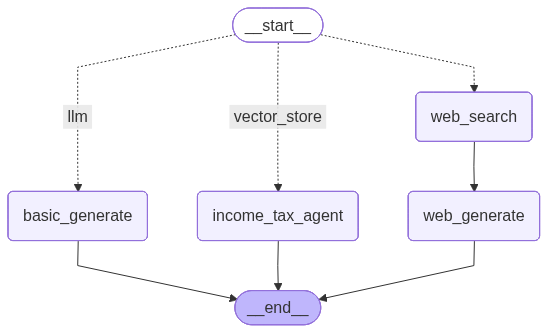

In [28]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [29]:
question = "연봉 5천만원 거주자의 소득세는 얼마인가요?"

initial_state = {
    "question": question
}

In [31]:
graph.invoke(initial_state)

ValidationError: 1 validation error for Generation
text
  Input should be a valid string [type=string_type, input_value=Router(target='vector_store'), input_type=Router]
    For further information visit https://errors.pydantic.dev/2.12/v/string_type